In [1]:
import warnings
warnings.filterwarnings('ignore')

In [73]:
import pandas as pd
import csv
import pickle
import statistics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.linear_model import Lasso
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from matplotlib_venn import venn2, venn2_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [3]:
# build the final data frame

# loading the dataset which has the features (gene symbol)
file_path = 'dataset/ADNI_Gene_Expression_Profile.csv'
df1 = pd.read_csv(file_path)

# df1.head()

col = df1.columns[3:747]
# print(len(c))
sampleList = []
for c in col:
    sample = df1.loc[:, c]
    sample = sample.tolist()
    sampleList.append(sample)
    
file_path = 'dataset/Complete_ADNI_clinical_info.csv'
df2 = pd.read_csv(file_path)

# df2.head(10)

tem_col = list(df1['Unnamed: 2'])
tem_col[1] = 'IID'

finalDataFrame = pd.DataFrame(sampleList, columns=tem_col)
finalDataFrame = finalDataFrame.loc[:, finalDataFrame.columns.notna()]
finalDataFrame = finalDataFrame.drop(columns=['Symbol'])

finalDataFrame['Age'] = ""
finalDataFrame['Gender'] = ""
finalDataFrame['Ethnicity'] = ""
finalDataFrame['Race'] = ""
finalDataFrame['Phenotype'] = ""

for index, row in finalDataFrame.iterrows():
    patientID = finalDataFrame.at[index, 'IID']
    # cell_value = df.at[row_number, column_name]
    #print("P ID: ", patient)
    for index2, row2 in df2.iterrows():
        if df2.at[index2, 'IID'] == patientID:
            finalDataFrame.at[index, 'Age'] = df2.at[index2, 'Age']
            finalDataFrame.at[index, 'Gender'] = df2.at[index2, 'Gender']
            finalDataFrame.at[index, 'Ethnicity'] = df2.at[index2, 'Ethnicity']
            finalDataFrame.at[index, 'Race'] = df2.at[index2, 'Race']
            finalDataFrame.at[index, 'Phenotype'] = df2.at[index2, 'Phenotype']

In [4]:
pickle_file_name = 'keyDictionaryPickel.pickle'
with open(pickle_file_name, 'rb') as file:
    keyDictionary = pickle.load(file)

In [5]:
geneMetrics = pd.read_csv("dataset/Gene_Metrics_Info.csv")

In [6]:
geneMetrics.head()

,Gene Symbol,Mean Standard Deviation,Mean Max,Mean Mean,Mean Median,Mean CV
0,HIST1H3G,0.2377,2.5467,2.2895,2.2987,0.1036
1,TNFAIP8L1,2.4977,7.0980,5.3318,5.3318,0.4695
2,OTOP2,0.3734,2.8182,2.5542,2.5542,0.1455
3,CTAGE6 || CTAGE15,0.3436,2.4837,2.2407,2.2407,0.1534
4,LINC01098,0.1168,2.4627,2.3801,2.3801,0.0490


In [7]:
lowHighGeneSymbolBasedOnStd = {}

for index, row in geneMetrics.iterrows():
    msd = geneMetrics.at[index, 'Mean Standard Deviation']
    key = geneMetrics.at[index, 'Gene Symbol']
    if msd > 1.5:
        lowHighGeneSymbolBasedOnStd[key] = 1
    else:
        lowHighGeneSymbolBasedOnStd[key] = 0

In [8]:
columns =  set(finalDataFrame.columns)
idxs = finalDataFrame["IID"]

In [9]:
dic = defaultdict(list)
for idx in idxs:
    for col in columns:
        res = keyDictionary.get((idx, col))
        if res:
            if lowHighGeneSymbolBasedOnStd[col] == 0:
                dic[col].append(np.mean(res))
            else:
                dic[col].append(np.median(res))
lastBasedOnStd = pd.DataFrame(dic)

In [10]:
original_col = finalDataFrame.columns
new_colBasedOnStd = lastBasedOnStd.columns
disjointBasedOnStd = [i for i in original_col if i not in new_colBasedOnStd]
lastBasedOnStd = lastBasedOnStd.merge(finalDataFrame[disjointBasedOnStd], left_index=True, right_index=True)

In [ ]:
# lastBasedOnStd = lastBasedOnStd.drop('IID', axis = 1)

In [11]:
lastBasedOnStd.replace("", np.nan, inplace=True)
print(sum(lastBasedOnStd.isna().sum()))
lastBasedOnStd = lastBasedOnStd[lastBasedOnStd["Phenotype"].notna()].reset_index(drop=True)
print(sum(lastBasedOnStd.isna().sum()))

80
0


In [12]:
for col in lastBasedOnStd.columns:
    if (
        any(lastBasedOnStd[col].isna())
        and lastBasedOnStd[col].isna().value_counts().to_dict().get(True) / len(lastBasedOnStd[col])
        > 0.90
    ):
        print(col)
        lastBasedOnStd = lastBasedOnStd.drop(col, axis=1)

In [13]:
featuresBasedOnStd = lastBasedOnStd.drop('Phenotype', axis = 1)
targetBasedOnStd = lastBasedOnStd['Phenotype']
featuresBasedOnStd = featuresBasedOnStd.drop('IID', axis = 1)

In [14]:
lasso1 = Lasso(alpha=0.01)
lasso1.fit(featuresBasedOnStd, targetBasedOnStd)
selectedFeaturesBasedOnStd = featuresBasedOnStd.columns[lasso1.coef_ != 0.0]

In [16]:
type(selectedFeaturesBasedOnStd)

pandas.core.indexes.base.Index

In [17]:
X = lastBasedOnStd[selectedFeaturesBasedOnStd]
y = lastBasedOnStd['Phenotype']

In [21]:
y.head()

0    2.0
1    0.0
2    2.0
3    0.0
4    1.0
Name: Phenotype, dtype: float64

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [35]:
y_train = y_train.values
y_test = y_test.values

In [39]:
y_train = y_train.astype(np.int)
y_test = y_test.astype(np.int)

In [42]:
parameterGrid = { 
    'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 200, num = 10)], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9], 
    'max_leaf_nodes': [3, 6, 9], 
}

In [45]:
a = [int(x) for x in np.linspace(start = 50, stop = 200, num = 10)]
print(a)

[50, 66, 83, 100, 116, 133, 150, 166, 183, 200]


In [43]:
gridSearch = GridSearchCV(RandomForestClassifier(), 
                           param_grid=parameterGrid) 
gridSearch.fit(X_train, y_train) 
print(gridSearch.best_estimator_)

RandomForestClassifier(max_depth=3, max_features=None, max_leaf_nodes=9)


In [46]:
model = RandomForestClassifier(n_estimators=150, max_depth=3, max_features=None, max_leaf_nodes=9, random_state=42)

In [47]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_features=None, max_leaf_nodes=9,
                       n_estimators=150, random_state=42)

In [48]:
y_pred = model.predict(X_test)

In [49]:
accuracy = accuracy_score(y_test, y_pred)

In [50]:
print(accuracy)

0.5273972602739726


In [74]:
cm = confusion_matrix(y_test, y_pred)

In [75]:
cmDF = pd.DataFrame(cm,
                     index = ['Control','MCI','AD'], 
                     columns = ['Control','MCI','AD'])

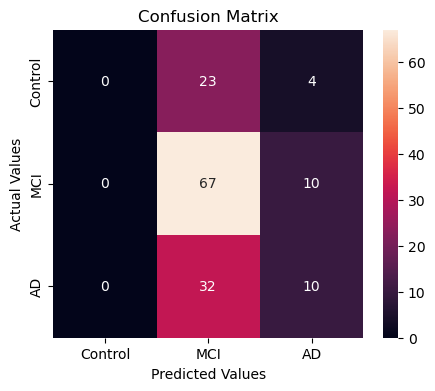

In [76]:
# plotting the confusion matrix to represent the preformance of Random Forest Model
plt.figure(figsize=(5,4))
sns.heatmap(cmDF, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [51]:
lowHighGeneSymbolBasedOnCV = {}

for index, row in geneMetrics.iterrows():
    mcv = geneMetrics.at[index, 'Mean CV']
    key = geneMetrics.at[index, 'Gene Symbol']
    if mcv > 0.35:
        lowHighGeneSymbolBasedOnCV[key] = 1
    else:
        lowHighGeneSymbolBasedOnCV[key] = 1

In [52]:
columns =  set(finalDataFrame.columns)
idxs = finalDataFrame["IID"]

In [53]:
dic = defaultdict(list)
for idx in idxs:
    for col in columns:
        res = keyDictionary.get((idx, col))
        if res:
            if lowHighGeneSymbolBasedOnCV[col] == 0:
                dic[col].append(np.mean(res))
            else:
                dic[col].append(np.median(res))
lastBasedOnCV = pd.DataFrame(dic)

In [54]:
original_col = finalDataFrame.columns
new_colBasedOnCV = lastBasedOnCV.columns
disjointBasedOnCV = [i for i in original_col if i not in new_colBasedOnCV]
lastBasedOnCV = lastBasedOnCV.merge(finalDataFrame[disjointBasedOnCV], left_index=True, right_index=True)

In [55]:
lastBasedOnCV.replace("", np.nan, inplace=True)
print(sum(lastBasedOnCV.isna().sum()))
lastBasedOnCV = lastBasedOnCV[lastBasedOnCV["Phenotype"].notna()].reset_index(drop=True)
print(sum(lastBasedOnCV.isna().sum()))

80
0


In [56]:
for col in lastBasedOnCV.columns:
    if (
        any(lastBasedOnCV[col].isna())
        and lastBasedOnCV[col].isna().value_counts().to_dict().get(True) / len(lastBasedOnCV[col])
        > 0.90
    ):
        print(col)
        lastBasedOnCV = lastBasedOnCV.drop(col, axis=1)

In [57]:
featuresBasedOnCV = lastBasedOnCV.drop('Phenotype', axis = 1)
targetBasedOnCV = lastBasedOnCV['Phenotype']
featuresBasedOnCV = featuresBasedOnCV.drop('IID', axis = 1)

In [58]:
lasso2 = Lasso(alpha=0.01)
lasso2.fit(featuresBasedOnCV, targetBasedOnCV)
selectedFeaturesBasedOnCV = featuresBasedOnCV.columns[lasso2.coef_ != 0.0]

In [59]:
len(selectedFeaturesBasedOnCV)

318

In [90]:
X2 = lastBasedOnCV[selectedFeaturesBasedOnCV]
y2 = lastBasedOnCV['Phenotype']

In [91]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [92]:
scaler2 = StandardScaler()
X_train2 = scaler2.fit_transform(X_train2)
X_test2 = scaler2.transform(X_test2)

In [93]:
y_train2 = y_train2.values
y_test2 = y_test2.values

In [94]:
y_train2 = y_train2.astype(np.int)
y_test2 = y_test2.astype(np.int)

In [95]:
model2 = RandomForestClassifier(n_estimators=150, max_depth=3, max_features=None, max_leaf_nodes=9, random_state=42)

In [96]:
model2.fit(X_train2, y_train2)

RandomForestClassifier(max_depth=3, max_features=None, max_leaf_nodes=9,
                       n_estimators=150, random_state=42)

In [97]:
y_pred2 = model2.predict(X_test2)

In [98]:
accuracy2 = accuracy_score(y_test2, y_pred2)

In [99]:
print(accuracy2)

0.547945205479452


In [100]:
cm2 = confusion_matrix(y_test2, y_pred2)

In [101]:
cmDF2 = pd.DataFrame(cm2,
                     index = ['Control','MCI','AD'], 
                     columns = ['Control','MCI','AD'])

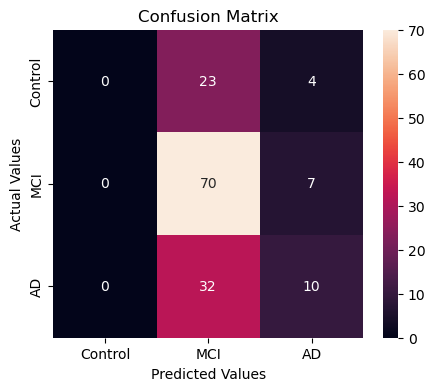

In [102]:
# plotting the confusion matrix to represent the preformance of Random Forest Model
plt.figure(figsize=(5,4))
sns.heatmap(cmDF2, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [103]:
selectedFeaturesBasedOnStdList = selectedFeaturesBasedOnStd.tolist()
selectedFeaturesBasedOnCVList = selectedFeaturesBasedOnCV.tolist()

In [104]:
print(len(selectedFeaturesBasedOnStdList))
print(len(selectedFeaturesBasedOnCVList))

322
318


In [105]:
inBothList = 0

for feature in selectedFeaturesBasedOnStdList:
    if feature in selectedFeaturesBasedOnCVList:
        inBothList += 1
        
onlyInFirstList = len(selectedFeaturesBasedOnStdList) - inBothList
onlyInSecondList = len(selectedFeaturesBasedOnCVList) - inBothList

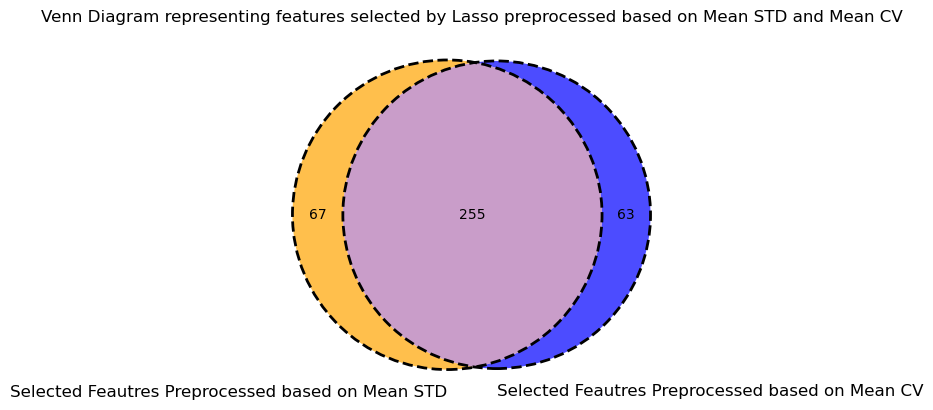

In [106]:
# depict venn diagram 
venn2(subsets=(onlyInFirstList, onlyInSecondList, inBothList),  
      set_labels=('Selected Feautres Preprocessed based on Mean STD', 'Selected Feautres Preprocessed based on Mean CV'), 
      set_colors=("orange", "blue"), alpha=.7) 
  
# add outline 
venn2_circles(subsets=(onlyInFirstList, onlyInSecondList, inBothList),  
              linestyle="dashed",  
              linewidth=2) 
  

# assign title of the venn diagram 
plt.title("Venn Diagram representing features selected by Lasso preprocessed based on Mean STD and Mean CV")   
plt.show()

In [107]:
for feature in selectedFeaturesBasedOnStdList:
    print(feature)

TMX3
WLS
RBPMS2
FXYD6-FXYD2 || FXYD2
CACUL1
PPAT
SPRY1
ZNF25
RALGPS2
HEY1
HSPA1B
BTNL8
AK5
ADK
FAM118A
RAP1GAP2
SFMBT2
ZNF397
ANGPTL1
AKR1C1
XIST
MRP63
GALNT14
BNIP1
FAM122B
ICA1
HIP1
SRD5A3
KCTD20
LOC391322
FGFR1OP
HP
DBP
CLEC4F
FMNL2
TCL1A
BTNL3
ITGB1
INPP4B
STAG3
ERAP2
S100B
LOC100653194 || SIRPB1
PLB1
FBXL13
FMN1
RHCE || RHD
EMR2
HLA-DQA1
GSTM4
POLR2A
TNNT1
PSPH
CD160
SMAD5
RPP30
USP53
CCNE2
ABAT
C19ORF35
DCLK2
CD177
MPZL2
IFT88
CCR3
RTCA
BACE2
TRIM66
OLFM4
TMEM159
TMEM168
TSC22D1
CLCN3
OLFM1
PIGR
TMEM45B
ADPRH
TRNP1
FAS
SH3YL1
NEK7
PPP2R2B
FRMD3
ABCC13
VEPH1
H2AFJ
STK17A
FAM46C
NKX3-1
RPL22L1
CA1
ZNF136
HLA-C
TMEM144
ABCA5
EGR1
MT1G
PFN1P2
HBEGF
DSC2
GPR34
TWSG1
ETV7
PEX6
TARSL2
CEACAM8
ZNF23
STIL
FAM3C
SLC22A15
P2RY14
CLEC4C
AFF3
FAM19A2
CXCL5
LOC101929373 || SLC9B1
SERINC2
ANKRD36 || ANKRD36B
VNN1
NAIP
EMC1
PTPRN2
HAL
IFI27
ZNF880
PRKAB2
PRDM1
RAB28
PISD
ALDH8A1
SETBP1
MILR1
PIKFYVE
TSC22D2
CHST13
GSTM3
ENSG00000211789
ARMCX1
ZNF621
SCGB1C1 || LOC653486
EXOC8
ITGB1BP1
CCNE1
H3F3

In [108]:
for feature in selectedFeaturesBasedOnCVList:
    print(feature)

WLS
PAM
PTPN12
RBPMS2
FXYD6-FXYD2 || FXYD2
CACUL1
PPAT
SPRY1
HEY1
HSPA1B
BTNL8
VANGL1
AK5
ADK
C9ORF84
FAM118A
AQP3
RAP1GAP2
ZNF397
ANGPTL1
AKR1C1
KDM4C
XIST
GALNT14
BNIP1
FAM122B
CACNB4
PROS1
SRD5A3
KCTD20
LOC391322
FGFR1OP
HP
C10ORF32-ASMT || AS3MT
DBP
FCGR2B
FMNL2
TCL1A
BTNL3
INPP4B
STAG3
S100B
METTL6
LOC100653194 || SIRPB1
FBXL13
FMN1
EMR2
HLA-DQA1
GSTM4
IFT74
POLR2A
TNNT1
PSPH
GID8
WDFY3
DLD
ADAT2
KIAA1841
ZNF326
CD160
SMAD5
RPP30
CCNE2
ABAT
C19ORF35
P21*
CD177
MPZL2
IFT88
ZSCAN12
KANK1
CCR3
ETV3
BACE2
TRIM66
OLFM4
TMEM159
TMEM168
CLCN3
COL6A3
OLFM1
C20ORF197
FBXW8
PIGR
TMEM45B
ADPRH
WARS
TRNP1
KIAA1407
FAS
SH3YL1
RFPL2
PPP2R2B
LOC101928218 || SMIM13
FRMD3
ABCC13
PRH1* || PRR4
H2AFJ
APOD
STK17A
BTN3A2
FAM46C
CD3EAP
CA1
HLA-C
TMEM144
EGR1
MT1G
HBEGF
EFNA5
DSC2
NLN
GPR34
ZFP1
TWSG1
ETV7
PEX6
TARSL2
ELOVL7
CEACAM8
ZNF23
FAM3C
SLC22A15
P2RY14
CLEC4C
MYEF2
FAM19A2
PCDH9
CXCL5
LOC101929373 || SLC9B1
TUBB2A
WDR92
SERINC2
ANKRD36 || ANKRD36B
VNN1
ASXL2
NAIP
HAL
IFI27
ZNF880
PRKAB2
PRDM1
RU